# 2D SRG-based Segmentation (perfect model)

This notebooks presents the process of SRG-based segmentation on an axial slice of liver MRI. The model will be built from the ground truth.

We will begin by building a model graph from the ground truth (GT), with four classes: liver (taken from GT), body (taken from GT's background class where `intensity > 10` after a closing operation), and backgrounds 1 & 2 (automatically split on y axis).

We will compute the following attributes:
* Centroid (vertex) and relative vector (edge)
* Mean intensity (vertex) and distance between mean intensities (edge)
* Area (vertex) and distance between areas (edge)

In [10]:
# Imports and declaration of a few util functions
%matplotlib inline

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from srg import SRG
from liver_2d_functions import *

import numpy as np
import pydicom
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from time import time
from copy import deepcopy
from scipy.ndimage.measurements import center_of_mass as measure_center_of_mass

import skimage
import skimage.segmentation as seg
import skimage.measure as measure
import skimage.filters as filters
import skimage.morphology as morph
import skimage.future.graph as graph

# Defining names and colors of the classes used
class_names = ["BG Left ", "BG Right", "BG Body ", "Liver   "]
class_colors = ListedColormap([[0,0,0],[0.1,0.1,0.1],[0.5,0.5,0.5],[0,0,1]])

# Weights for cost
initial_weights = (2,10,50)
vertex_weights = (2,10,50,30)
edge_weights = (2,10,50,30)
graph_weights = (1,1)

def window_level(image, w=400, l=100):
    """Window-levels the image."""
    leveled = image.astype(float)
    leveled = (leveled-(l-(w/2)))/(w)
    leveled[leveled < 0.0] = 0.0
    leveled[leveled > 1.0] = 1.0
    return leveled

In [2]:
# Loading slice for building model
loaded_image = pydicom.read_file("notebooks_data/2d_liver_slices/4_upper.dcm").pixel_array
loaded_truth = skimage.io.imread("notebooks_data/2d_liver_slices/ground_truth/4_upper.png")

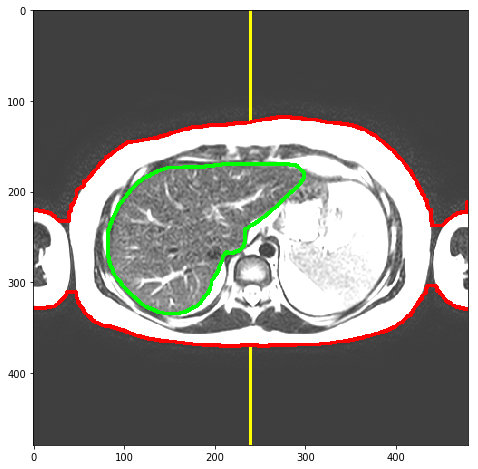

In [3]:
# Deepcopying the model image
model_image = deepcopy(loaded_image)
# Reconfiguring the model labelmap
model_labelmap = np.zeros_like(loaded_truth)
# Splitting background class (everything is already zero, so we just need to set the right of the image to 1)
model_labelmap[:,model_labelmap.shape[1]//2:] = 1
# Computing body class
model_labelmap[morph.closing(
            morph.opening(
            loaded_image > 10,selem=morph.square(6)),
            selem=morph.square(10))] = 2
# Adding liver class
model_labelmap[loaded_truth>0]=3

# Showing model image with truth
plt.figure(figsize=(8,8))
plt.imshow(seg.mark_boundaries(
                seg.mark_boundaries(
                    seg.mark_boundaries(window_level(model_image),
                    model_labelmap, mode="thick",outline_color=(1,1,0)), # backgrounds as yellow
                model_labelmap==2, mode="thick",color=(1,0,0),outline_color=(1,0,0)), # Body as red
            model_labelmap==3, mode="thick",color=(0,1,0),outline_color=(0,1,0))) # liver as green

In [4]:
# Generating model graph
model_graph = build_graph(model_image, model_labelmap)
model_graph, mean_vertex, std_vertex, mean_edge, std_edge = normalize_graph(model_graph)
print("Model:",represent_srg(model_graph, class_names=class_names))

# TODO: maybe a visualization of the graph, overlayed on the image? needs work but possible

Model: SRG with 4 vertices and 16 edges
Stat attrs: ['centroid_x', 'centroid_y', 'intensity', 'size']; Rel attrs: ['position_x', 'position_y', 'contrast', 'ratio']
#	Classes		|centroid_x	|centroid_y	|intensity	|size
0	BG Left 	|-0.958		|-1.216		|-0.796		|0.557	
1	BG Right	|-0.700		|1.450		|-0.795		|0.496	
2	BG Body 	|1.610		|0.326		|1.653		|0.675	
3	Liver   	|0.048		|-0.559		|-0.062		|-1.728	



### Observation
We now begin the process of segmenting the observation. First, we will utilize watershed to automatically segment the image, producing a supersegmentation. Further details can be found in the Jupyter Notebook `2d_supersegmentation`, adjacent to this one.

Superobservation: SRG with 221 vertices and 0 edges
Stat attrs: ['centroid_x', 'centroid_y', 'intensity', 'size']; Rel attrs: []
#	Classes		|centroid_x	|centroid_y	|intensity	|size
0			|-0.843		|-1.218		|-0.755		|0.519	
1			|-0.407		|1.457		|-0.768		|0.394	
2			|-13.330		|0.840		|-0.693		|-2.721	
3			|-12.900		|-0.151		|-0.696		|-2.781	
4			|-11.143		|0.466		|2.624		|-2.741	
5			|-10.691		|0.897		|2.705		|-2.762	
6			|-10.912		|0.160		|2.493		|-2.796	
7			|-9.057		|-0.797		|2.498		|-2.611	
8			|-10.613		|1.178		|2.891		|-2.783	
9			|-7.333		|1.581		|3.006		|-2.713	
10			|-8.874		|1.219		|2.742		|-2.789	
11			|-9.023		|0.591		|-0.138		|-2.787	
12			|-8.741		|-0.286		|-0.137		|-2.780	
13			|-9.021		|0.372		|0.352		|-2.799	
14			|-7.437		|0.054		|-0.148		|-2.784	
15			|-8.326		|0.213		|-0.020		|-2.785	
16			|-8.305		|-0.513		|0.432		|-2.788	
17			|-7.909		|-0.085		|0.221		|-2.790	
18			|-8.721		|0.856		|0.522		|-2.795	
19			|-8.364		|0.992		|0.689		|-2.805	
20			|-1.195		|-0.794		|-0.172	

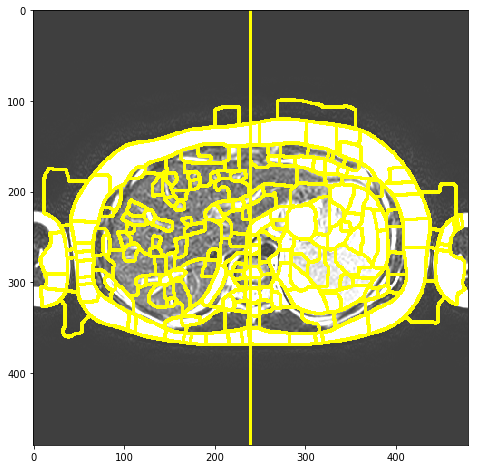

In [18]:
# Deepcopying the observation image
observation_image = deepcopy(loaded_image)

def watershed(image, sigma=5, r=5):
    """Compute a simple watershed on the Sobel of the image."""
    smoothed = skimage.filters.gaussian(image, sigma) # smooth with gaussian
    smoothed = smoothed/np.max(smoothed) # normalization to [0-1]
    magnitude = skimage.filters.sobel(smoothed) # Sobel for magnitude
    local_minima = skimage.morphology.local_minima(magnitude, selem=skimage.morphology.disk(r)) # get local minima
    markers = skimage.measure.label(local_minima) # label local minima
    return skimage.morphology.watershed(magnitude, markers)-1 # watershed; the -1 is for zeroing the background

def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color."""

    diff = graph.node[dst]['mean color'] - graph.node[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}

def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph."""
    graph.node[dst]['total color'] += graph.node[src]['total color']
    graph.node[dst]['pixel count'] += graph.node[src]['pixel count']
    graph.node[dst]['mean color'] = (graph.node[dst]['total color'] /
                                     graph.node[dst]['pixel count'])

    
# Super-segmentation and merging (threshold is 15)
super_labelmap = watershed(observation_image)
rag = graph.rag_mean_color(observation_image, super_labelmap)
super_labelmap = graph.merge_hierarchical(super_labelmap, rag, thresh=15, rag_copy=False,
                               in_place_merge=True,
                               merge_func=merge_mean_color,
                               weight_func=_weight_mean_color)

# We force-split the middle of the image. This is also automatic!
super_labelmap[:,super_labelmap.shape[1]//2:] += np.max(super_labelmap)+1
super_labelmap = measure.label(super_labelmap)-1

plt.figure(figsize=(8,8))
plt.imshow(seg.mark_boundaries(window_level(observation_image), super_labelmap, mode="thick",outline_color=(1,1,0)))
#plt.imshow(super_labelmap, cmap=ListedColormap(np.random.rand(255,3)))

# Generating super-observation graph
super_graph = build_graph(observation_image, super_labelmap, add_edges=False)
super_graph = normalize_graph(super_graph,mean_vertex, std_vertex, mean_edge, std_edge)
super_adjacency = graph.RAG(super_labelmap)
print("Superobservation:",represent_srg(super_graph))

# TODO: visualizing the super graph might also be cool

### Initial Solution
Next, we will generate an initial solution, by matching closest vertex (ignoring edge and size information). This will give us both a base upon which to compute SRG similarity (and attempt to improve it), and a rough ranking of the quality of a vertex matching (based on its matching cost).

The weights chosen are based on qualitative exploration. The centroid-x seems to be unhelpful in this scenario; looking at the values for the model and super graphs, it seems clear that the relatively small variability in the model does not translate well into the super-graph, with super-vertices having centroid-x values in the $[-13,13]$ range.

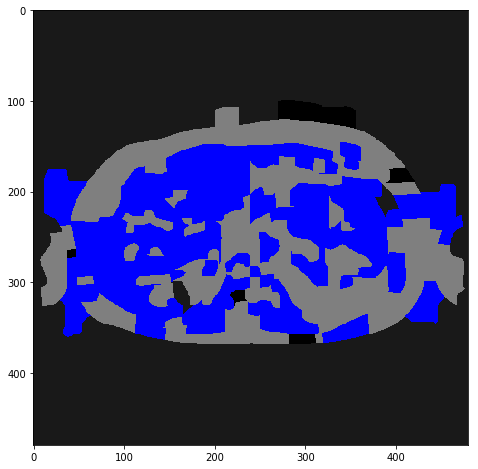

In [6]:
# Computing initial solution
solution = np.empty(super_graph.vertices.shape[0])
solution_costs = np.empty_like(solution)
for i, super_vertex in enumerate(super_graph.vertices):
    # Computing cost to all model vertices
    super_vertex_matrix = np.vstack([super_vertex]*model_graph.vertices.shape[0])
    costs = compute_initial_vertex_cost(super_vertex_matrix, model_graph.vertices, weights=initial_weights)
    solution[i] = np.argmin(costs)
    solution_costs[i] = np.min(costs)

# Showing initial solution
observation_labelmap = np.zeros_like(super_labelmap)
for label, model_vertex in enumerate(model_graph.vertices):
    observation_labelmap[np.isin(super_labelmap, np.where(solution==label))]=label
plt.figure(figsize=(8,8))
plt.imshow(observation_labelmap,cmap=class_colors)
#plt.imshow(seg.mark_boundaries(
#                seg.mark_boundaries(
#                    seg.mark_boundaries(window_level(observation_image),
#                    observation_labelmap, mode="thick",outline_color=(1,1,0)), # backgrounds as yellow
#                observation_labelmap==2, mode="thick",color=(1,0,0),outline_color=(1,0,0)), # Body as red
#            observation_labelmap==3, mode="thick",color=(0,1,0),outline_color=(0,1,0))) # liver as green

### Contiguity guarantee

We now guarantee the contiguity of all labels in the solution.

End of contiguity guarantee
Contiguous Solution (Costs: 0.666,0.797), Dice: 0.4700
Observation: SRG with 4 vertices and 16 edges
Stat attrs: ['centroid_x', 'centroid_y', 'intensity', 'size']; Rel attrs: ['position_x', 'position_y', 'contrast', 'ratio']
#	Classes		|centroid_x	|centroid_y	|intensity	|size
0	BG Left 	|-0.989		|-1.180		|-0.248		|1.650	
1	BG Right	|0.412		|1.255		|0.065		|2.476	
2	BG Body 	|-0.493		|0.424		|1.164		|-2.383	
3	Liver   	|2.405		|-0.304		|0.612		|-1.743	



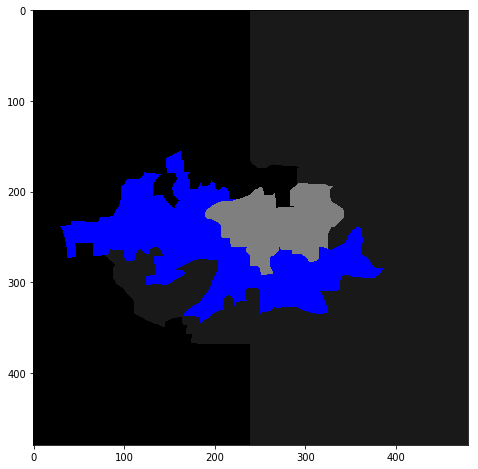

In [23]:
# Step 6: Contiguity guarantee
# -----------------------
# Detecting non-contiguous regions
for label, model_vertex in enumerate(model_graph.vertices):
    # label = 0
    # model_vertex = model_graph.vertices[0]
    # Get all contiguous regions for this label
    label_regions = np.where(solution==label)
    solution_map = np.isin(super_labelmap , label_regions)
    # Label connected components
    potential_region_map, potential_region_count = ndi.label(solution_map)
    if potential_region_count == 1: # No need to change contiguous predictions
        continue

    # Computing vertex attributes for each connected component
    potential_region_super_graph = build_graph(observation_image, potential_region_map, add_edges=False)
    potential_region_super_graph = normalize_graph(potential_region_super_graph,mean_vertex, std_vertex, mean_edge, std_edge)
    # Computing costs
    model_label_vertex_matrix = np.vstack([model_vertex]*potential_region_super_graph.vertices.shape[0])
    costs = compute_initial_vertex_cost(potential_region_super_graph.vertices, model_label_vertex_matrix, weights=initial_weights)
    actual_region = (np.argmin(costs[1:])) + 1 # Actual region is the one with the lowest cost; however, do note it can never be region zero
    # Determining which supervertexes compose the actual region
    correct_vertexes = np.unique(super_labelmap[potential_region_map==actual_region])
    # Marking other regions for improvement
    solution[label_regions] = -1
    solution[correct_vertexes] = label

# Running improvement for non-contiguous regions
while -1 in solution:
    observation_labelmap = np.zeros_like(super_labelmap)
    for label, model_vertex in enumerate(model_graph.vertices):
        observation_labelmap[np.isin(super_labelmap, np.where(solution==label))]=label
    for super_vertex_index, super_vertex in sorted(enumerate(solution_costs), key=lambda x: x[1], reverse=True):
        if solution[super_vertex_index] > -1:
            continue # Ignore continuous regions, for now

        potential_predictions = set([solution[neighbour] for neighbour in super_adjacency.adj[super_vertex_index].keys()])

        current_cost = float("inf")
        current_prediction_index = solution[super_vertex_index]
        print("Modifying supervertex {} (curr: {}, cost: {:.6f})".format(super_vertex_index, current_prediction_index, current_cost))

        # Soft contiguity: potential predictions may only be neighboring labels
        for potential_prediction_index in potential_predictions:
            # Skipping same replacements
            if potential_prediction_index == current_prediction_index: continue
            if potential_prediction_index == -1: continue

            # Replacing the current prediction with the potential
            working_labelmap_data = deepcopy(observation_labelmap)
            working_labelmap_data[super_labelmap==super_vertex_index] = potential_prediction_index

            # Updating graph
            working_graph = build_graph(observation_image, working_labelmap_data, target_vertices=model_graph.vertices.shape[0])
            working_graph = normalize_graph(working_graph, mean_vertex, std_vertex, mean_edge, std_edge)

            # Computing costs
            potential_vertex_costs = compute_vertex_cost(working_graph.vertices, model_graph.vertices, weights=vertex_weights)
            potential_edge_costs = compute_edge_cost(working_graph.edges, model_graph.edges)
            potential_cost = graph_weights[0]*np.mean(potential_vertex_costs) + graph_weights[1]*np.mean(potential_edge_costs)
            print("\tAttempting replace with {}, cost: {:.6f}".format(potential_prediction_index, potential_cost))
            # Improving if better
            if potential_cost < current_cost:
                current_prediction_index = potential_prediction_index
                current_vertex_costs = potential_vertex_costs
                current_edge_costs = potential_edge_costs
                current_cost = potential_cost

        print("\t* Replaced with {}".format(current_prediction_index))

        solution[super_vertex_index] = current_prediction_index

# End of an epoch, rebuilding the joined graph
print("End of contiguity guarantee")
observation_labelmap = np.zeros_like(super_labelmap)
for label, model_vertex in enumerate(model_graph.vertices):
    observation_labelmap[np.isin(super_labelmap, np.where(solution==label))]=label
observation_graph = build_graph(observation_image, observation_labelmap, target_vertices=model_graph.vertices.shape[0])
observation_graph = normalize_graph(observation_graph, mean_vertex, std_vertex, mean_edge, std_edge)
vertex_costs = compute_vertex_cost(observation_graph.vertices, model_graph.vertices, weights=vertex_weights)
edge_costs = compute_edge_cost(observation_graph.edges, model_graph.edges, weights=edge_weights)
dice = (2. * np.logical_and(observation_labelmap==3, model_labelmap == 3)).sum()/((observation_labelmap==3).sum() + (model_labelmap == 3).sum())
print("Contiguous Solution (Costs: {:.3f},{:.3f}), Dice: {:.4f}".format(np.mean(vertex_costs),np.mean(edge_costs), dice))
print("Observation:",represent_srg(observation_graph, class_names=class_names))

plt.figure(figsize=(8,8))
plt.imshow(observation_labelmap,cmap=class_colors)


### Improvement
Finally, we'll perform improvement on the solution found, to reduce its cost.

Modifying supervertex 0 (curr: 0.0, cost: 0.420997)
	Attempting replace with 1.0, cost: nan
	Attempting replace with 2.0, cost: nan
	Attempting replace with 3.0, cost: nan
	* Replaced with 0.0
Modifying supervertex 1 (curr: 1.0, cost: 0.420997)
	Attempting replace with 0.0, cost: 2.200858
	Attempting replace with 2.0, cost: 2.134867
	Attempting replace with 3.0, cost: 2.066185
	* Replaced with 1.0
Modifying supervertex 2 (curr: 1.0, cost: 0.420997)
	* Replaced with 1.0
Modifying supervertex 3 (curr: 3.0, cost: 0.420997)
	Attempting replace with 0.0, cost: 0.521610
	Attempting replace with 2.0, cost: 0.518885
	* Replaced with 3.0
Modifying supervertex 4 (curr: 1.0, cost: 0.420997)
	Attempting replace with 3.0, cost: 0.567627
	* Replaced with 1.0
Modifying supervertex 5 (curr: 1.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.508298
	* Replaced with 1.0
Modifying supervertex 6 (curr: 3.0, cost: 0.420997)
	Attempting replace with 1.0, cost: 0.527965
	Attempting replace with 2.0, 

	Attempting replace with 3.0, cost: 0.531587
	* Replaced with 2.0
Modifying supervertex 81 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.530975
	* Replaced with 3.0
Modifying supervertex 82 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.528904
	* Replaced with 3.0
Modifying supervertex 83 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 84 (curr: 1.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.532928
	* Replaced with 1.0
Modifying supervertex 85 (curr: 2.0, cost: 0.420997)
	Attempting replace with 3.0, cost: 0.531072
	* Replaced with 2.0
Modifying supervertex 86 (curr: 2.0, cost: 0.420997)
	Attempting replace with 1.0, cost: 0.535015
	* Replaced with 2.0
Modifying supervertex 87 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.534796
	* Replaced with 3.0
Modifying supervertex 88 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.532249
	* Replaced with 3.0
Modifying supervertex 89 (c

	Attempting replace with 3.0, cost: 0.532111
	* Replaced with 2.0
Modifying supervertex 168 (curr: 2.0, cost: 0.420997)
	Attempting replace with 3.0, cost: 0.530401
	* Replaced with 2.0
Modifying supervertex 169 (curr: 2.0, cost: 0.420997)
	Attempting replace with 3.0, cost: 0.529488
	* Replaced with 2.0
Modifying supervertex 170 (curr: 2.0, cost: 0.420997)
	Attempting replace with 3.0, cost: 0.523993
	* Replaced with 2.0
Modifying supervertex 171 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 172 (curr: 2.0, cost: 0.420997)
	Attempting replace with 1.0, cost: 0.523228
	* Replaced with 2.0
Modifying supervertex 173 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 174 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 175 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 176 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 177 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modi

	Attempting replace with 3.0, cost: 0.540709
	* Replaced with 2.0
Modifying supervertex 29 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.528889
	* Replaced with 3.0
Modifying supervertex 30 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.526256
	* Replaced with 3.0
Modifying supervertex 31 (curr: 2.0, cost: 0.420997)
	Attempting replace with 3.0, cost: 0.543644
	* Replaced with 2.0
Modifying supervertex 32 (curr: 2.0, cost: 0.420997)
	Attempting replace with 3.0, cost: 0.537927
	* Replaced with 2.0
Modifying supervertex 33 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.530828
	* Replaced with 3.0
Modifying supervertex 34 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.529515
	* Replaced with 3.0
Modifying supervertex 35 (curr: 2.0, cost: 0.420997)
	Attempting replace with 1.0, cost: 0.543215
	* Replaced with 2.0
Modifying supervertex 36 (curr: 3.0, cost: 0.420997)
	Attempting replace with 0.0, cost: 0.555847
	At

	Attempting replace with 2.0, cost: 0.535915
	* Replaced with 3.0
Modifying supervertex 114 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.539711
	* Replaced with 3.0
Modifying supervertex 115 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.545071
	* Replaced with 3.0
Modifying supervertex 116 (curr: 2.0, cost: 0.420997)
	Attempting replace with 3.0, cost: 0.527447
	* Replaced with 2.0
Modifying supervertex 117 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 118 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 119 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.548441
	* Replaced with 3.0
Modifying supervertex 120 (curr: 2.0, cost: 0.420997)
	Attempting replace with 1.0, cost: 0.535441
	* Replaced with 2.0
Modifying supervertex 121 (curr: 2.0, cost: 0.420997)
	Attempting replace with 3.0, cost: 0.533893
	* Replaced with 2.0
Modifying supervertex 122 (curr: 3.0, cost: 0.420997)
	Attemptin

	Attempting replace with 1.0, cost: 0.534816
	* Replaced with 2.0
Modifying supervertex 214 (curr: 2.0, cost: 0.420997)
	Attempting replace with 0.0, cost: 0.535107
	* Replaced with 2.0
Modifying supervertex 215 (curr: 2.0, cost: 0.420997)
	Attempting replace with 0.0, cost: 0.535401
	* Replaced with 2.0
Modifying supervertex 216 (curr: 2.0, cost: 0.420997)
	Attempting replace with 0.0, cost: 0.535827
	* Replaced with 2.0
Modifying supervertex 217 (curr: 2.0, cost: 0.420997)
	Attempting replace with 1.0, cost: 0.534044
	* Replaced with 2.0
Modifying supervertex 218 (curr: 2.0, cost: 0.420997)
	Attempting replace with 0.0, cost: 0.534322
	* Replaced with 2.0
Modifying supervertex 219 (curr: 2.0, cost: 0.420997)
	Attempting replace with 0.0, cost: 0.534655
	* Replaced with 2.0
Modifying supervertex 220 (curr: 2.0, cost: 0.420997)
	Attempting replace with 1.0, cost: 0.533767
	* Replaced with 2.0
End of epoch #1
Epoch 1 Solution (Costs: 0.185,0.236), Dice: 0.3089
Observation: SRG with 4 ve

	Attempting replace with 3.0, cost: 0.533881
	* Replaced with 2.0
Modifying supervertex 69 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.534764
	* Replaced with 3.0
Modifying supervertex 70 (curr: 2.0, cost: 0.420997)
	Attempting replace with 3.0, cost: 0.533120
	* Replaced with 2.0
Modifying supervertex 71 (curr: 2.0, cost: 0.420997)
	Attempting replace with 3.0, cost: 0.527887
	* Replaced with 2.0
Modifying supervertex 72 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.499020
	* Replaced with 3.0
Modifying supervertex 73 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.534858
	* Replaced with 3.0
Modifying supervertex 74 (curr: 3.0, cost: 0.420997)
	* Replaced with 3.0
Modifying supervertex 75 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.535300
	* Replaced with 3.0
Modifying supervertex 76 (curr: 2.0, cost: 0.420997)
	Attempting replace with 3.0, cost: 0.533923
	* Replaced with 2.0
Modifying supervertex 77 (c

	Attempting replace with 2.0, cost: 0.535620
	* Replaced with 3.0
Modifying supervertex 152 (curr: 2.0, cost: 0.420997)
	Attempting replace with 3.0, cost: 0.531460
	* Replaced with 2.0
Modifying supervertex 153 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 154 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 155 (curr: 2.0, cost: 0.420997)
	Attempting replace with 3.0, cost: 0.530038
	* Replaced with 2.0
Modifying supervertex 156 (curr: 2.0, cost: 0.420997)
	Attempting replace with 0.0, cost: 0.538346
	* Replaced with 2.0
Modifying supervertex 157 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 158 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 159 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.541356
	* Replaced with 3.0
Modifying supervertex 160 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 161 (curr: 2.0, cost: 0.420997)
	Attempting replace with 

	Attempting replace with 1.0, cost: 0.544026
	* Replaced with 2.0
Modifying supervertex 11 (curr: 1.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.528260
	Attempting replace with 3.0, cost: 0.536769
	* Replaced with 1.0
Modifying supervertex 12 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.523997
	* Replaced with 3.0
Modifying supervertex 13 (curr: 1.0, cost: 0.420997)
	Attempting replace with 3.0, cost: 0.535549
	* Replaced with 1.0
Modifying supervertex 14 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.527896
	* Replaced with 3.0
Modifying supervertex 15 (curr: 3.0, cost: 0.420997)
	Attempting replace with 1.0, cost: 0.531937
	* Replaced with 3.0
Modifying supervertex 16 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.525477
	* Replaced with 3.0
Modifying supervertex 17 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.527456
	* Replaced with 3.0
Modifying supervertex 18 (curr: 2.0, cost: 0.420997)
	At

	Attempting replace with 2.0, cost: 0.529762
	* Replaced with 3.0
Modifying supervertex 95 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 96 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.535224
	* Replaced with 3.0
Modifying supervertex 97 (curr: 2.0, cost: 0.420997)
	Attempting replace with 0.0, cost: 0.535280
	Attempting replace with 3.0, cost: 0.531739
	* Replaced with 2.0
Modifying supervertex 98 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.534148
	* Replaced with 3.0
Modifying supervertex 99 (curr: 2.0, cost: 0.420997)
	Attempting replace with 3.0, cost: 0.534761
	* Replaced with 2.0
Modifying supervertex 100 (curr: 2.0, cost: 0.420997)
	Attempting replace with 3.0, cost: 0.532829
	* Replaced with 2.0
Modifying supervertex 101 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 102 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.536070
	* Replaced with 3.0
Modifying supervertex 10

	Attempting replace with 3.0, cost: 0.528725
	* Replaced with 2.0
Modifying supervertex 179 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 180 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 181 (curr: 2.0, cost: 0.420997)
	Attempting replace with 0.0, cost: 0.538489
	* Replaced with 2.0
Modifying supervertex 182 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 183 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 184 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 185 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 186 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 187 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 188 (curr: 2.0, cost: 0.420997)
	Attempting replace with 0.0, cost: 0.526617
	* Replaced with 2.0
Modifying supervertex 189 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervert

	Attempting replace with 2.0, cost: 0.529515
	* Replaced with 3.0
Modifying supervertex 35 (curr: 2.0, cost: 0.420997)
	Attempting replace with 1.0, cost: 0.543215
	* Replaced with 2.0
Modifying supervertex 36 (curr: 3.0, cost: 0.420997)
	Attempting replace with 0.0, cost: 0.555847
	Attempting replace with 2.0, cost: 0.554236
	* Replaced with 3.0
Modifying supervertex 37 (curr: 3.0, cost: 0.420997)
	* Replaced with 3.0
Modifying supervertex 38 (curr: 3.0, cost: 0.420997)
	* Replaced with 3.0
Modifying supervertex 39 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.533185
	* Replaced with 3.0
Modifying supervertex 40 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.533207
	* Replaced with 3.0
Modifying supervertex 41 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.533381
	* Replaced with 3.0
Modifying supervertex 42 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.533372
	* Replaced with 3.0
Modifying supervertex 43 (c

	Attempting replace with 3.0, cost: 0.528608
	* Replaced with 2.0
Modifying supervertex 110 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.535252
	* Replaced with 3.0
Modifying supervertex 111 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.534375
	* Replaced with 3.0
Modifying supervertex 112 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 113 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.535915
	* Replaced with 3.0
Modifying supervertex 114 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.539711
	* Replaced with 3.0
Modifying supervertex 115 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.545071
	* Replaced with 3.0
Modifying supervertex 116 (curr: 2.0, cost: 0.420997)
	Attempting replace with 3.0, cost: 0.527447
	* Replaced with 2.0
Modifying supervertex 117 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 118 (curr: 2.0, cost: 0.420997)
	* Replace

	Attempting replace with 0.0, cost: 0.538809
	* Replaced with 2.0
Modifying supervertex 208 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 209 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 210 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 211 (curr: 2.0, cost: 0.420997)
	Attempting replace with 0.0, cost: 0.534767
	* Replaced with 2.0
Modifying supervertex 212 (curr: 2.0, cost: 0.420997)
	Attempting replace with 0.0, cost: 0.534185
	Attempting replace with 1.0, cost: 0.534079
	* Replaced with 2.0
Modifying supervertex 213 (curr: 2.0, cost: 0.420997)
	Attempting replace with 1.0, cost: 0.534816
	* Replaced with 2.0
Modifying supervertex 214 (curr: 2.0, cost: 0.420997)
	Attempting replace with 0.0, cost: 0.535107
	* Replaced with 2.0
Modifying supervertex 215 (curr: 2.0, cost: 0.420997)
	Attempting replace with 0.0, cost: 0.535401
	* Replaced with 2.0
Modifying supervertex 216 (curr: 2.0, cost: 0.420997)
	Attemptin

	Attempting replace with 2.0, cost: 0.522330
	* Replaced with 3.0
Modifying supervertex 57 (curr: 3.0, cost: 0.420997)
	* Replaced with 3.0
Modifying supervertex 58 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.534353
	* Replaced with 3.0
Modifying supervertex 59 (curr: 2.0, cost: 0.420997)
	Attempting replace with 3.0, cost: 0.537920
	* Replaced with 2.0
Modifying supervertex 60 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.537416
	* Replaced with 3.0
Modifying supervertex 61 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.533878
	* Replaced with 3.0
Modifying supervertex 62 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 63 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.534431
	* Replaced with 3.0
Modifying supervertex 64 (curr: 2.0, cost: 0.420997)
	Attempting replace with 3.0, cost: 0.536706
	* Replaced with 2.0
Modifying supervertex 65 (curr: 2.0, cost: 0.420997)
	Attempting replace

	Attempting replace with 2.0, cost: 0.537221
	* Replaced with 3.0
Modifying supervertex 146 (curr: 2.0, cost: 0.420997)
	Attempting replace with 3.0, cost: 0.529834
	* Replaced with 2.0
Modifying supervertex 147 (curr: 2.0, cost: 0.420997)
	Attempting replace with 3.0, cost: 0.527232
	* Replaced with 2.0
Modifying supervertex 148 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.540398
	* Replaced with 3.0
Modifying supervertex 149 (curr: 2.0, cost: 0.420997)
	Attempting replace with 3.0, cost: 0.525813
	* Replaced with 2.0
Modifying supervertex 150 (curr: 2.0, cost: 0.420997)
	Attempting replace with 3.0, cost: 0.526025
	* Replaced with 2.0
Modifying supervertex 151 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.535620
	* Replaced with 3.0
Modifying supervertex 152 (curr: 2.0, cost: 0.420997)
	Attempting replace with 3.0, cost: 0.531460
	* Replaced with 2.0
Modifying supervertex 153 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervert

	Attempting replace with 0.0, cost: 0.614360
	Attempting replace with 3.0, cost: 0.702452
	* Replaced with 2.0
Modifying supervertex 8 (curr: 1.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.519535
	* Replaced with 1.0
Modifying supervertex 9 (curr: 2.0, cost: 0.420997)
	Attempting replace with 1.0, cost: 0.583490
	Attempting replace with 3.0, cost: 0.617919
	* Replaced with 2.0
Modifying supervertex 10 (curr: 2.0, cost: 0.420997)
	Attempting replace with 1.0, cost: 0.544026
	* Replaced with 2.0
Modifying supervertex 11 (curr: 1.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.528260
	Attempting replace with 3.0, cost: 0.536769
	* Replaced with 1.0
Modifying supervertex 12 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.523997
	* Replaced with 3.0
Modifying supervertex 13 (curr: 1.0, cost: 0.420997)
	Attempting replace with 3.0, cost: 0.535549
	* Replaced with 1.0
Modifying supervertex 14 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost

	Attempting replace with 1.0, cost: 0.535015
	* Replaced with 2.0
Modifying supervertex 87 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.534796
	* Replaced with 3.0
Modifying supervertex 88 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.532249
	* Replaced with 3.0
Modifying supervertex 89 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 90 (curr: 2.0, cost: 0.420997)
	Attempting replace with 1.0, cost: 0.539007
	* Replaced with 2.0
Modifying supervertex 91 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.534841
	* Replaced with 3.0
Modifying supervertex 92 (curr: 2.0, cost: 0.420997)
	Attempting replace with 3.0, cost: 0.538632
	* Replaced with 2.0
Modifying supervertex 93 (curr: 2.0, cost: 0.420997)
	Attempting replace with 3.0, cost: 0.530356
	* Replaced with 2.0
Modifying supervertex 94 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.529762
	* Replaced with 3.0
Modifying supervertex 95 (c

	Attempting replace with 1.0, cost: 0.536752
	* Replaced with 2.0
Modifying supervertex 206 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 207 (curr: 2.0, cost: 0.420997)
	Attempting replace with 0.0, cost: 0.538809
	* Replaced with 2.0
Modifying supervertex 208 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 209 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 210 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 211 (curr: 2.0, cost: 0.420997)
	Attempting replace with 0.0, cost: 0.534767
	* Replaced with 2.0
Modifying supervertex 212 (curr: 2.0, cost: 0.420997)
	Attempting replace with 0.0, cost: 0.534185
	Attempting replace with 1.0, cost: 0.534079
	* Replaced with 2.0
Modifying supervertex 213 (curr: 2.0, cost: 0.420997)
	Attempting replace with 1.0, cost: 0.534816
	* Replaced with 2.0
Modifying supervertex 214 (curr: 2.0, cost: 0.420997)
	Attempting replace with 0.0, cost: 0.535107
	* Replace

	Attempting replace with 2.0, cost: 0.534067
	* Replaced with 3.0
Modifying supervertex 56 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.522330
	* Replaced with 3.0
Modifying supervertex 57 (curr: 3.0, cost: 0.420997)
	* Replaced with 3.0
Modifying supervertex 58 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.534353
	* Replaced with 3.0
Modifying supervertex 59 (curr: 2.0, cost: 0.420997)
	Attempting replace with 3.0, cost: 0.537920
	* Replaced with 2.0
Modifying supervertex 60 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.537416
	* Replaced with 3.0
Modifying supervertex 61 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.533878
	* Replaced with 3.0
Modifying supervertex 62 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 63 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.534431
	* Replaced with 3.0
Modifying supervertex 64 (curr: 2.0, cost: 0.420997)
	Attempting replace

	Attempting replace with 2.0, cost: 0.535915
	* Replaced with 3.0
Modifying supervertex 140 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 141 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 142 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 143 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 144 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 145 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.537221
	* Replaced with 3.0
Modifying supervertex 146 (curr: 2.0, cost: 0.420997)
	Attempting replace with 3.0, cost: 0.529834
	* Replaced with 2.0
Modifying supervertex 147 (curr: 2.0, cost: 0.420997)
	Attempting replace with 3.0, cost: 0.527232
	* Replaced with 2.0
Modifying supervertex 148 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.540398
	* Replaced with 3.0
Modifying supervertex 149 (curr: 2.0, cost: 0.420997)
	Attempting replace with 

	Attempting replace with 0.0, cost: 0.614360
	Attempting replace with 3.0, cost: 0.702452
	* Replaced with 2.0
Modifying supervertex 8 (curr: 1.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.519535
	* Replaced with 1.0
Modifying supervertex 9 (curr: 2.0, cost: 0.420997)
	Attempting replace with 1.0, cost: 0.583490
	Attempting replace with 3.0, cost: 0.617919
	* Replaced with 2.0
Modifying supervertex 10 (curr: 2.0, cost: 0.420997)
	Attempting replace with 1.0, cost: 0.544026
	* Replaced with 2.0
Modifying supervertex 11 (curr: 1.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.528260
	Attempting replace with 3.0, cost: 0.536769
	* Replaced with 1.0
Modifying supervertex 12 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.523997
	* Replaced with 3.0
Modifying supervertex 13 (curr: 1.0, cost: 0.420997)
	Attempting replace with 3.0, cost: 0.535549
	* Replaced with 1.0
Modifying supervertex 14 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost

	Attempting replace with 3.0, cost: 0.531072
	* Replaced with 2.0
Modifying supervertex 86 (curr: 2.0, cost: 0.420997)
	Attempting replace with 1.0, cost: 0.535015
	* Replaced with 2.0
Modifying supervertex 87 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.534796
	* Replaced with 3.0
Modifying supervertex 88 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.532249
	* Replaced with 3.0
Modifying supervertex 89 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 90 (curr: 2.0, cost: 0.420997)
	Attempting replace with 1.0, cost: 0.539007
	* Replaced with 2.0
Modifying supervertex 91 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.534841
	* Replaced with 3.0
Modifying supervertex 92 (curr: 2.0, cost: 0.420997)
	Attempting replace with 3.0, cost: 0.538632
	* Replaced with 2.0
Modifying supervertex 93 (curr: 2.0, cost: 0.420997)
	Attempting replace with 3.0, cost: 0.530356
	* Replaced with 2.0
Modifying supervertex 94 (c

	Attempting replace with 0.0, cost: 0.526617
	* Replaced with 2.0
Modifying supervertex 189 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 190 (curr: 2.0, cost: 0.420997)
	Attempting replace with 0.0, cost: 0.546634
	* Replaced with 2.0
Modifying supervertex 191 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 192 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 193 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 194 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 195 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 196 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 197 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 198 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 199 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 200 (curr: 2.0, cost: 0.420997)
	* Replace

	Attempting replace with 0.0, cost: 0.555847
	Attempting replace with 2.0, cost: 0.554236
	* Replaced with 3.0
Modifying supervertex 37 (curr: 3.0, cost: 0.420997)
	* Replaced with 3.0
Modifying supervertex 38 (curr: 3.0, cost: 0.420997)
	* Replaced with 3.0
Modifying supervertex 39 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.533185
	* Replaced with 3.0
Modifying supervertex 40 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.533207
	* Replaced with 3.0
Modifying supervertex 41 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.533381
	* Replaced with 3.0
Modifying supervertex 42 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.533372
	* Replaced with 3.0
Modifying supervertex 43 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.533546
	* Replaced with 3.0
Modifying supervertex 44 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.530954
	* Replaced with 3.0
Modifying supervertex 45 (c

	Attempting replace with 2.0, cost: 0.539711
	* Replaced with 3.0
Modifying supervertex 115 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.545071
	* Replaced with 3.0
Modifying supervertex 116 (curr: 2.0, cost: 0.420997)
	Attempting replace with 3.0, cost: 0.527447
	* Replaced with 2.0
Modifying supervertex 117 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 118 (curr: 2.0, cost: 0.420997)
	* Replaced with 2.0
Modifying supervertex 119 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.548441
	* Replaced with 3.0
Modifying supervertex 120 (curr: 2.0, cost: 0.420997)
	Attempting replace with 1.0, cost: 0.535441
	* Replaced with 2.0
Modifying supervertex 121 (curr: 2.0, cost: 0.420997)
	Attempting replace with 3.0, cost: 0.533893
	* Replaced with 2.0
Modifying supervertex 122 (curr: 3.0, cost: 0.420997)
	Attempting replace with 2.0, cost: 0.534249
	* Replaced with 3.0
Modifying supervertex 123 (curr: 3.0, cost: 0.420997)
	Attemptin

	Attempting replace with 0.0, cost: 0.535827
	* Replaced with 2.0
Modifying supervertex 217 (curr: 2.0, cost: 0.420997)
	Attempting replace with 1.0, cost: 0.534044
	* Replaced with 2.0
Modifying supervertex 218 (curr: 2.0, cost: 0.420997)
	Attempting replace with 0.0, cost: 0.534322
	* Replaced with 2.0
Modifying supervertex 219 (curr: 2.0, cost: 0.420997)
	Attempting replace with 0.0, cost: 0.534655
	* Replaced with 2.0
Modifying supervertex 220 (curr: 2.0, cost: 0.420997)
	Attempting replace with 1.0, cost: 0.533767
	* Replaced with 2.0
End of epoch #9
Epoch 9 Solution (Costs: 0.185,0.236), Dice: 0.3089
Observation: SRG with 4 vertices and 16 edges
Stat attrs: ['centroid_x', 'centroid_y', 'intensity', 'size']; Rel attrs: ['position_x', 'position_y', 'contrast', 'ratio']
#	Classes		|centroid_x	|centroid_y	|intensity	|size
0	BG Left 	|-0.843		|-1.218		|-0.755		|0.519	
1	BG Right	|-1.222		|1.406		|-0.618		|0.651	
2	BG Body 	|3.126		|0.101		|1.286		|0.561	
3	Liver   	|-3.142		|0.069		|0

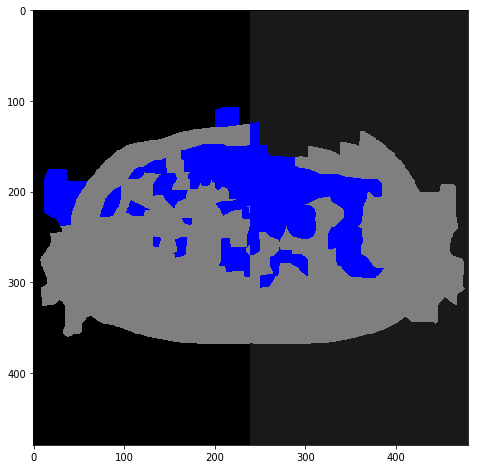

In [30]:
total_epochs = 10#len(solution)//2
improvement_cutoff = len(solution) # TODO: convergence? cutoff by cost difference?
for epoch in range(total_epochs):
    # attempting to improve each vertex, starting from the most expensive
    for super_vertex_index, _ in sorted(enumerate(solution_costs), key=lambda x: x[1], reverse=True)[:improvement_cutoff]:
    #for super_vertex_index in [np.argmax(solution_costs)]:
        current_prediction_index = solution[super_vertex_index]
        current_vertex_costs = compute_vertex_cost(observation_graph.vertices, model_graph.vertices, weights=vertex_weights)
        current_edge_costs = compute_edge_cost(observation_graph.edges, model_graph.edges, weights=edge_weights)
        current_cost = graph_weights[0]*np.mean(current_vertex_costs) + graph_weights[1]*np.mean(current_edge_costs)

        print("Modifying supervertex {} (curr: {}, cost: {:.6f})".format(super_vertex_index, current_prediction_index, current_cost))

        # Soft contiguity: potential predictions may only be neighboring labels
        potential_predictions = set([solution[neighbour] for neighbour in super_adjacency.adj[super_vertex_index].keys()])
        for potential_prediction_index in potential_predictions:
            # Skipping same replacements
            if potential_prediction_index == current_prediction_index: continue

            # Replacing the current prediction with the potential
            working_labelmap_data = deepcopy(observation_labelmap)
            working_labelmap_data[super_labelmap==super_vertex_index] = potential_prediction_index

            # Updating graph
            working_graph = build_graph(observation_image, working_labelmap_data, target_vertices=model_graph.vertices.shape[0])
            working_graph = normalize_graph(working_graph, mean_vertex, std_vertex, mean_edge, std_edge)

            # Computing costs
            potential_vertex_costs = compute_vertex_cost(working_graph.vertices, model_graph.vertices, weights=vertex_weights)
            potential_edge_costs = compute_edge_cost(working_graph.edges, model_graph.edges)
            potential_cost = graph_weights[0]*np.mean(potential_vertex_costs) + graph_weights[1]*np.mean(potential_edge_costs)
            print("\tAttempting replace with {}, cost: {:.6f}".format(potential_prediction_index, potential_cost))
            # Improving if better
            if potential_cost < current_cost:
                current_prediction_index = potential_prediction_index
                current_vertex_costs = potential_vertex_costs
                current_edge_costs = potential_edge_costs
                current_cost = potential_cost

        solution[super_vertex_index] = current_prediction_index
        solution_costs[super_vertex_index] = 0#np.mean(current_vertex_costs)

        print("\t* Replaced with {}".format(current_prediction_index))

    # End of an epoch, rebuilding the joined graph
    print("End of epoch #{}".format(epoch))
    observation_labelmap = np.zeros_like(super_labelmap)
    for element, prediction in enumerate(solution):
        observation_labelmap[super_labelmap==element]=prediction
    observation_graph = build_graph(observation_image, observation_labelmap, target_vertices=model_graph.vertices.shape[0])
    observation_graph = normalize_graph(observation_graph, mean_vertex, std_vertex, mean_edge, std_edge)
    vertex_costs = compute_vertex_cost(observation_graph.vertices, model_graph.vertices, weights=vertex_weights)
    edge_costs = compute_edge_cost(observation_graph.edges, model_graph.edges, weights=edge_weights)
    dice = (2. * np.logical_and(observation_labelmap==3, model_labelmap == 3)).sum()/((observation_labelmap==3).sum() + (model_labelmap == 3).sum())
    print("Epoch {} Solution (Costs: {:.3f},{:.3f}), Dice: {:.4f}".format(epoch, np.mean(vertex_costs),np.mean(edge_costs), dice))
    print("Observation:",represent_srg(observation_graph, class_names=class_names))

dice = (2. * np.logical_and(observation_labelmap==3, model_labelmap == 3)).sum()/((observation_labelmap==3).sum() + (model_labelmap == 3).sum())
dice_average = np.mean([dice_coefficient(observation_labelmap==label, model_labelmap == label) for label in range(len(model_graph.vertices))])
print("Epoch {} Solution (Costs: {:.3f},{:.3f}), LiverDice: {:.4f}, AvgDice: {:.4f}".format(epoch, np.mean(vertex_costs),np.mean(edge_costs), dice, dice_average))


plt.figure(figsize=(8,8))
plt.imshow(observation_labelmap,cmap=class_colors)
